In [1]:
import numpy as np
import random
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

In [2]:
%pip install torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 821.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# The Ising Model Setup

Notes:

*   The magnetc moment $𝜇$ of each spin variable can take a value of $±1$.
*   Aside from the interaction between nearest spins, we consider an external magnetic field $B$.
*  The Hamiltonian is given by:
 $$
 H = -J\sum_{i,j}s_is_j-𝜇\sum{j}B_js_j
 $$
 With $J$ being the interaction strenght between nearest spins


*   Without an external field, the system exhibits a phase shift when the Curie Temperatura ($T_c$) is reached








## Setting up the lattice

In [3]:
np.random.seed(20)

"This function generates a grid of size (N,N) and assigns a random value of -1 or 1 to each element"

def initialize(N: int):
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

N=4
test=initialize(N)
print(test)


[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]


##The Hamiltonian: getting the energy of the system

Using wrap around coordinates, we calculate the Hamiltonian considering $J = 1$ and no external field. The sum over the spin pairs is done in a way that the spin in a position $(i,j)$ is affected by it´s neighbor in the position $(i,j+1)$. In this coordinate system, the rows and column are 'connected' in the sense that the last position has an effect on the first one.

In [4]:
"This function returns the energy of the grid"
def hamiltonian(iArr, N: int):
    energy = 1/2 * sum(-iArr[i][j] * ( iArr[i][(j+1) % N] + iArr[i][(j-1) % N]+ iArr[(i+1) % N][j] + iArr[(i-1) % N][j]) for i in range(N) for j in range (N))
    # the 1/2 is to account for the double counting
    return energy

hamiltonian(test,N)
#print energy should be 4

4.0

## Evolving spin configurations

First, we set up a flip function that changes the spin of the $i, j-th$ element of the grid according to a function that depends on the change of energy.

For instance, the state of that element will be changed if

$$
p < e^{(-ΔH β)}
$$

where $β=\frac{1}{k_BT}$ and we consider $k_B = 1$


###¿ How do we understand the probability of changing the state of an element?

The Monte Carlo Algorythm creates lattice configurations that, together, approximate a Boltzman distribution. Here, the probability of a state is proportional to the Boltzman factor; then, the ratio of the probabilities of two states is equal to such factor. With $T=1$ this is

$$
\frac{P(a)}{P(b)} = \frac{e^{-H_a}}{e^{-H_b}} = e^{-(H_a-H_b)}
$$

If we consider a change form state $b$ to state $a$, in this case from $s_i$ to $-s_i$, and the change lowers the energy, it should happen. So, if $ΔH < 0$ the change sould definitely be made, and if $ΔH > 0$ the change sould be made with a probability of $e^{-ΔH}$. This last part means that if a random number between $0$ and $1$ (uniform distribution) is smaller than $e^{-ΔH}$, the spin of the element will switch sign.

Note: the change in energy for one element is:

$$
H_f-H_i = -(-S_i)S_{j} - (-S_iS_{j})=2S_iS_{j}
$$

https://sites.physics.wustl.edu/gradcomputer/wiki/images/6/63/Ising_notes_v2.pdf


In [5]:
"This function tries to change the value of the i, j-th element of the grid"

def flip(i: int, j: int, iArr, Beta: float):
  M = len(iArr)
  deltaH = 2*iArr[i][j]*(iArr[i][(j+1)%M] + iArr[i][(j-1)%M] + iArr[(i+1)%M][j] + iArr[(i-1)%M][j])
  if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*Beta)):
    iArr[i][j] *= -1
  return iArr

print("Before Flip:\n",test)
flip(2,1,test,1)
print("After Flip:\n",test)
#the 2,1 element should go from -1 to 1

Before Flip:
 [[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
After Flip:
 [[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1  1  1 -1]
 [-1 -1 -1  1]]


Magnetization

$$
M = \sum_{i} S_i
$$

In [6]:
"This function returns the magnetization of the system"
def mag(iArr):
  M = sum(iArr[i][j] for i in range(len(iArr)) for j in range(len(iArr)))
  return M
print("magnetization:",mag(test)) #Should be zero if you flipped 2,1 correctly, otherwise from raw is -2

magnetization: 0


In [7]:
"update_rand will use the flip function to try to flip every element in the grid, vising every position randomly and only once"

def update_rand(iArr,N,TM1):
  index = [(row, col) for row in range(N) for col in range(N)]
  samples = random.sample(index, N*N)
  for n in range(len(samples)):
    flip(samples[n][0], samples[n][1], iArr, TM1)
  return iArr


update_rand(test, N, 1)
test

array([[-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1, -1, -1]])

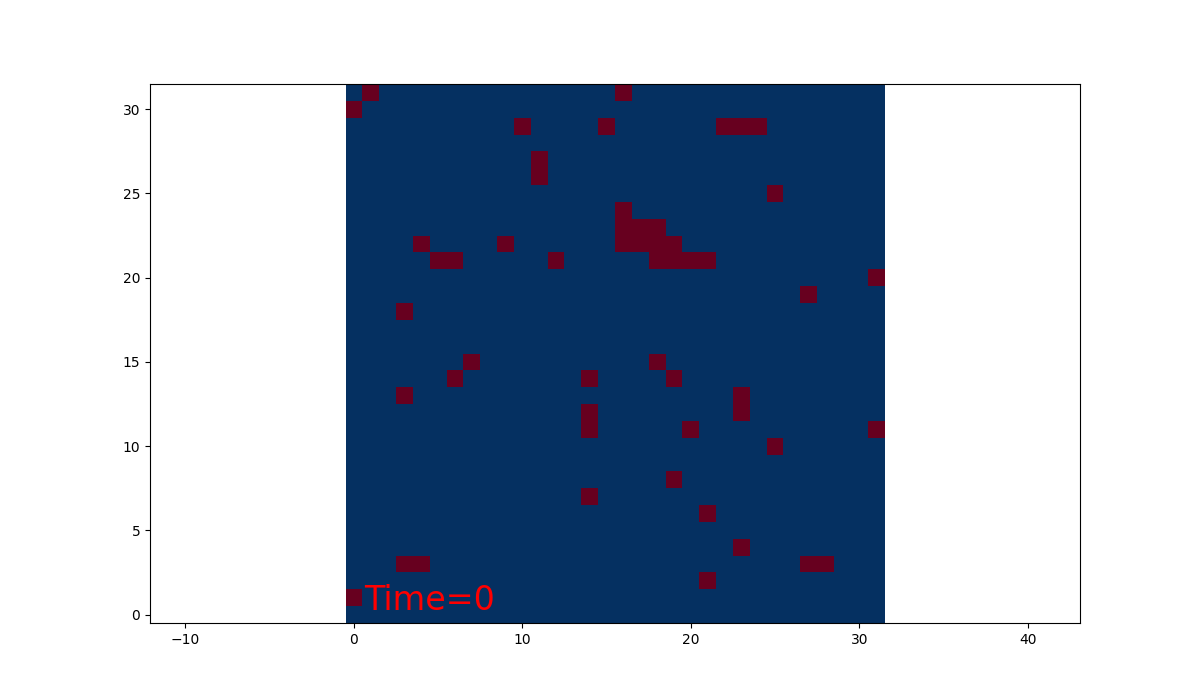

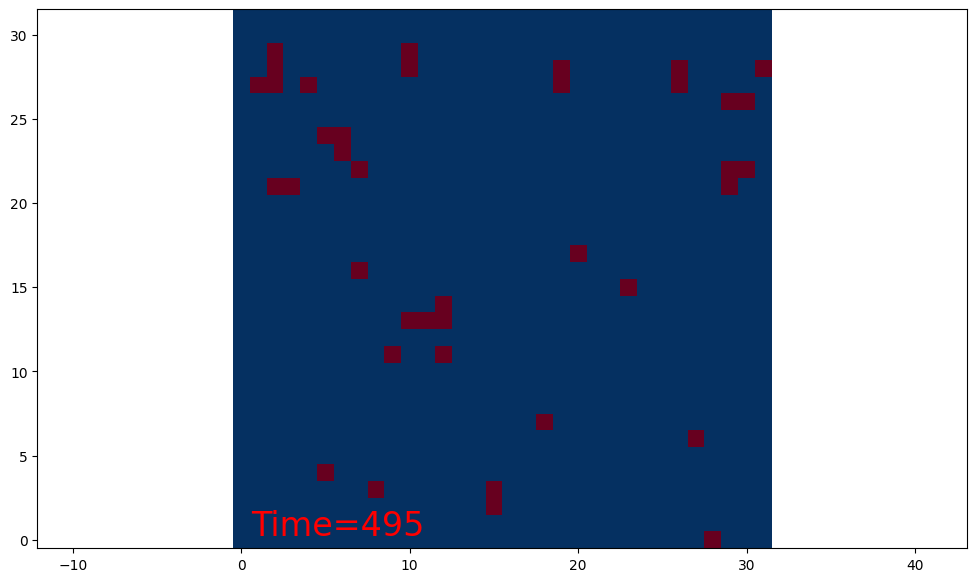

In [8]:
from IPython.display import Image

def mapPlot(ax,fig, iArr, i, N, images):
    plt.cla()
    X, Y = np.meshgrid(range(N), range(N))
    #plt.setp(sp.get_yticklabels(), visible=False)
    #plt.setp(sp.get_xticklabels(), visible=False)
    plt.axis('equal')
    ax.pcolormesh(X, Y, iArr, cmap=plt.cm.RdBu);
    ax.text(0.6, 0.3,'Time=%d'%i,fontdict={'size': 24, 'color':  'red'})#; plt.axis('tight')
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def runTemp(iT,iN,images,fig,ax,eqSteps=500,mcSteps=500):
    pArr = initialize(iN)         # initialise
    beta=1.0/iT
    for i in range(eqSteps):         # equilibrate
        update_rand(pArr, iN, beta)

    for i in range(mcSteps):
        update_rand(pArr, iN, beta)
        Ene = hamiltonian(pArr, iN)     # calculate the energy
        Mag = mag(pArr)        # calculate the magnetisation
        if i % 5 == 0:
            mapPlot(ax,fig,pArr,i,iN,images)

images=[]
fig, ax = plt.subplots(figsize=(12,7))
runTemp(2.00,32,images,fig,ax)
imageio.mimsave('./test.gif', images, fps=10)
Image(open('test.gif','rb').read())

Playing around with the temperatures, we notice that for very low temperatures (close to 0) the system has a net magnetization and all (or almost all) spins have the same value. For larger temperatures (around 2.3), it becomes increasingly'disorganized'.

## Modeling the phase transition

For this part, we consider

$$
⟨E⟩ = \frac{1}{Z}\sum_{σ}He^{-Hβ}
$$

$$
⟨M⟩ = \frac{1}{Z}\sum_{σ}Me^{-Hβ}
$$

$$
C = \frac{⟨E^2⟩-\langle E\rangle ^2}{T^2}
$$

$$
\chi = \frac{⟨M^2⟩-\langle M\rangle ^2}{T}
$$

Here, $Z$ is the partition function, that in this case is

$$
Z = \sum_{σ} e^{-Hβ}
$$

and the sum is taken over the states

In [9]:
"This function initialices a grid of size (iN, iN) and calculates the quantities shown above for a given temperature iT     \
as the system evolves a number of steps"

def runTemp(iT,iN,images,fig,ax,eqSteps=500,mcSteps=500):
    pArr = initialize(iN)                     # initialise
    Esum1, Esum2, Msum1, Msum2, Z= 0, 0, 0, 0, 0
    beta=1.0/iT

    for i in range(eqSteps):                  # equilibrate
        update_rand(pArr, iN, beta)

    for i in range(mcSteps):
        update_rand(pArr, iN, beta)

        Ene = hamiltonian(pArr, iN)           # calculate the energy
        Esum1 += Ene*np.exp(-Ene*beta)
        Esum2 += Ene**2*np.exp(-Ene*beta)

        Mag = mag(pArr)                       # calculate the magnetisation
        Msum1 += np.abs(Mag)*np.exp(-Ene*beta)
        Msum2 += np.abs(Mag)**2*np.exp(-Ene*beta)

        Z += np.exp(-Ene*beta)

    #compute the values for E,M,C,X here
    E = Esum1/Z
    M = Msum1/Z
    C = (Esum2/Z -E**2)/iT**2
    X = (Msum2/Z -M**2)/iT
    return E,M,C,X

In [10]:
N = 5
nt = 100
T  = np.linspace(1.5,3.3,nt)
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
    E[temp],M[temp],C[temp],X[temp] = runTemp(T[temp],N,images,fig,ax,eqSteps=500,mcSteps=500)

Loading...: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


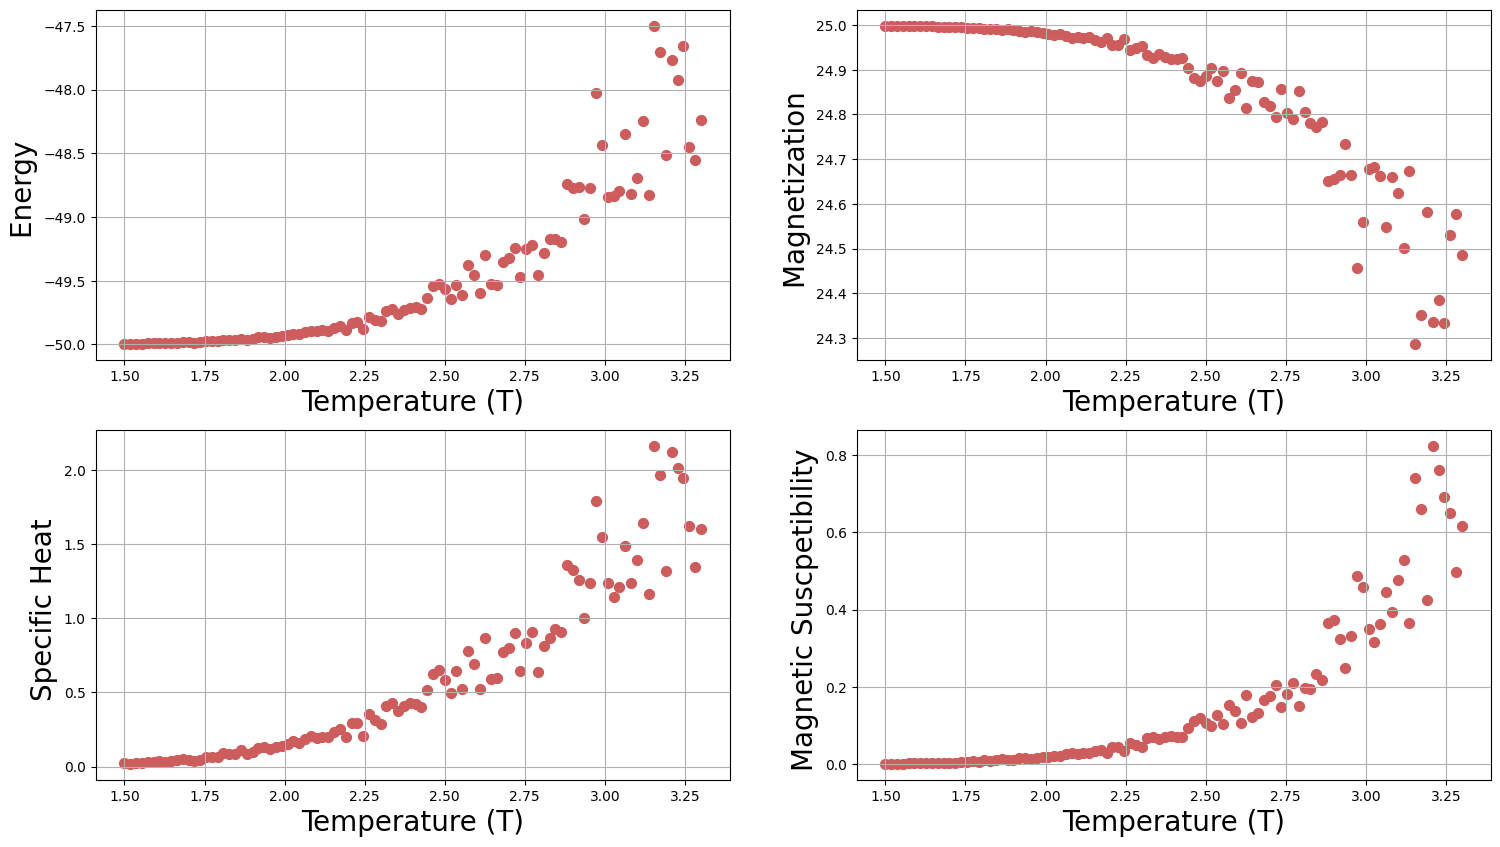

In [11]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid()


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, M, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid()

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid()

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid()

With this plot we identify that, as the temperature grows, these quantities show a change in value that starts around T = 2.25. This can be considered where the phase transition occurs.

In [12]:
Tc = 2/np.log(1 + np.sqrt(2))
print('Analytic critical temperature: ', Tc)

Analytic critical temperature:  2.269185314213022


# Constructing Ising Model Simulation

We create a class to evolve a configuration at a given temperature T and save the evolved state to a dataset

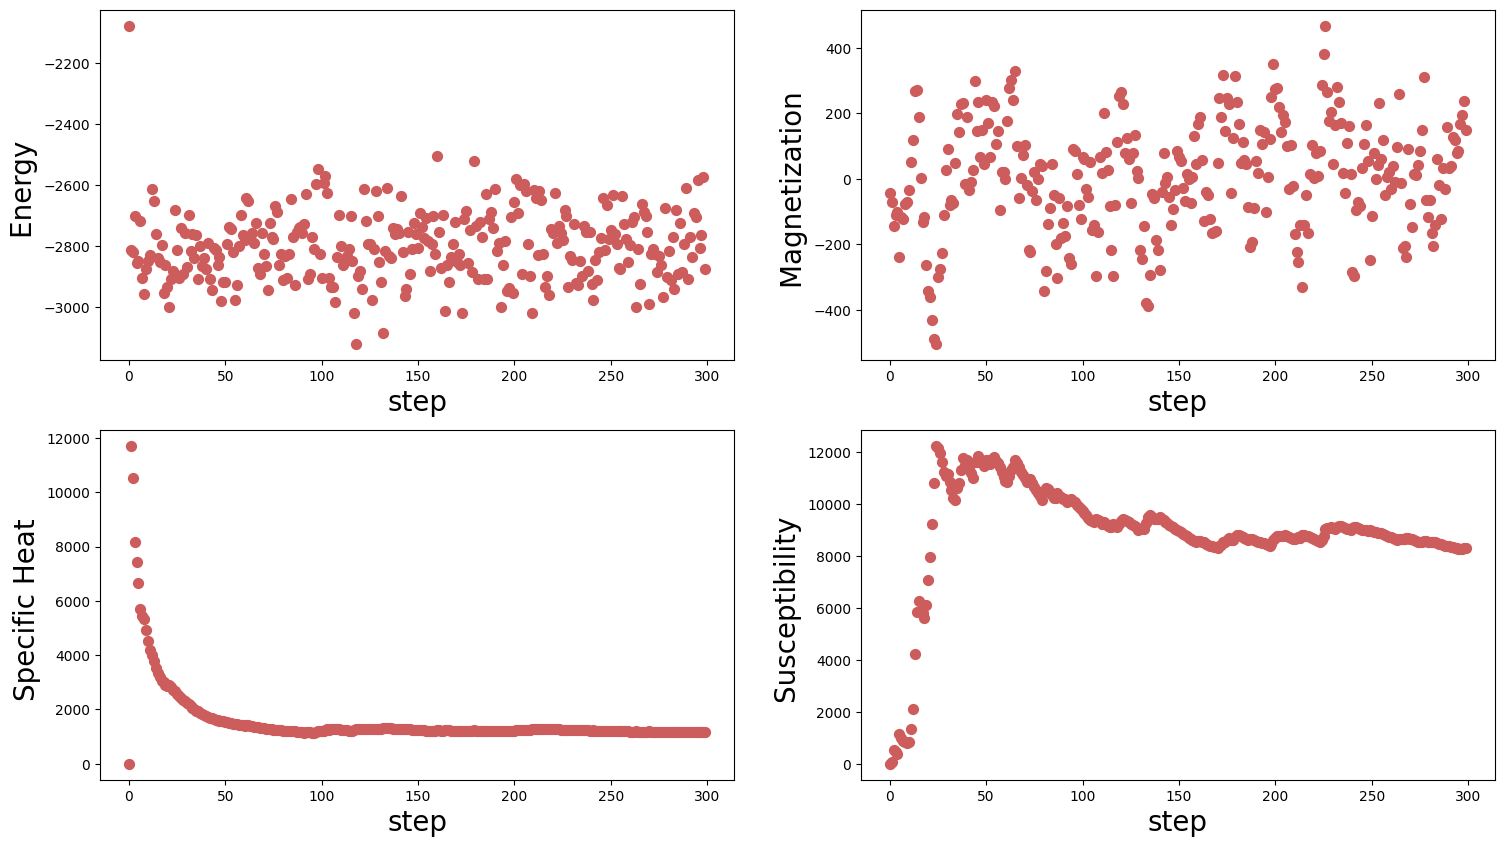

In [13]:
import h5py
class Ising():

    def __init__(self, iN, Temp):
        self.N   = iN
        self.T   = Temp
        self.arr = self.initialize()
        self.steps = 300
        #History over simulation
        self.E   = np.array([])
        self.M   = np.array([])
        self.C   = np.array([])
        self.X   = np.array([])
        self.nsim = 1000

    "creates the lattice"
    def initialize(self):
        state = 2*np.random.randint(2, size=(self.N,self.N))-1
        return state

    "updates the state 300 times and saves the energy, magnetization, heat capacity and magnetic susceptibiliyty for each step"
    def simulate(self):
        beta = 1./self.T
        for i in range(self.steps):
            update_rand(self.arr, self.N, beta)
            Ene = hamiltonian(self.arr, self.N)
            Mag = mag(self.arr)
            #Now save energy magnetization
            self.E   = np.append(self.E,Ene)  # arrays with 300 positions
            self.M   = np.append(self.M,Mag)

            #Now COMPUTE specific Heat and Magnetic suscpetilibity
            #HINT, consider what the meaning of RMS of Energy and Magnetization are
            #Perhaps consider a sliding window over the last hundred steps
            rmsE = np.mean([e**2 for e in self.E])
            rmsM = np.mean([m**2 for m in self.M])
            pC  = (rmsE - np.mean(self.E)**2)*beta**2
            pX  = (rmsM - np.mean(self.M)**2)*beta
            self.C   = np.append(self.C,pC)
            self.X   = np.append(self.X,pX)


    "This method creates 'nsim' grids and evolves them. Then, saves the final state of the grid and the magnetization of each system,"
    def simulate_save(self,pre=''):

        h5f  = h5py.File((pre)+'data_'+str(self.T)+'.h5', 'a')     #this allows to or create or append (if it already exists) to a file
        data = np.array([])   #np.empty((1,self.N,self.N), int)
        mags = np.array([])
        TM1  = 1./self.T
        for n in range(self.nsim):
            if n % 25 == 0:
                print("sim",n)
            self.initialize()
            ## Add code to run simulate the ising model nsteps
            ## update self.arr
            self.simulate()
            update_rand(self.arr,self.N,self.T)

            #for each simulation we want to save the magnetization and the array
            pMag = mag(self.arr)
            data = np.append(self.arr,data)
            mags  = np.append(pMag,mags)

        #now we write the output array into a dataset
        data = np.reshape(data,(self.nsim,self.N,self.N))
        h5f.create_dataset('data', data=data)    # This creates a dataset in the file with the evolved arrays
        h5f.create_dataset('mag' , data=mags)    # This creates a datset in the file with the magnetization of the evolved arrays
        h5f.close()

    "Calculates mean values over the arrays"
    def lastAvg(self):
        avgE = np.mean(self.E)
        avgM = np.mean(self.M)
        avgC = np.std(self.E)
        avgX = np.std(self.M)
        return avgE,avgM,avgC,avgX


    def plotEvol(self):
        ts = range(len(self.E))
        f = plt.figure(figsize=(18, 10)); #
        plt.tight_layout()

        sp =  f.add_subplot(2, 2, 1 );
        plt.scatter(ts, self.E, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

        #PLOT THE MAGNETIZATION, SPECIFIC HEAT AND SUSCEPTIBILITY

        sp =  f.add_subplot(2, 2, 2 );
        plt.scatter(ts, self.M, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');

        sp =  f.add_subplot(2, 2, 3 );
        plt.scatter(ts, self.C, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');

        sp =  f.add_subplot(2, 2, 4 );
        plt.scatter(ts, self.X, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Susceptibility ", fontsize=20);         plt.axis('tight');


test = Ising(64,3.4)
test.simulate()
test.plotEvol()

Notice the energy and magnertic susceptibility fluctuate a lot. This is because the temperatutre is set to 3.4, therefore, the system is above the critical temperature that was found.

## Constructing simulation

We create an object of the class Ising with atributes T (a value from a list of temperatures) and N=32 (Meaning our grid will be 32 x 32). We then create a file for each of the temperatures and call the simulate_save method to run the Ising Model and create datasets of evolved arrays and their magnetization for each temperature in T

In [14]:
import os
nt=20
T = np.round(np.linspace(1.53, 3.28, nt),2)
print(T)
for temp in tqdm (range (nt), desc="Loading..."):
    #Some hacky code to clean up things
    filename='data_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(32,T[temp])
    test.nsim=10  #500 =>10
    test.simulate_save()

f = h5py.File('data_1.53.h5', 'r')
list(f.keys())
f['data'].shape
!ls

[1.53 1.62 1.71 1.81 1.9  1.99 2.08 2.17 2.27 2.36 2.45 2.54 2.64 2.73
 2.82 2.91 3.   3.1  3.19 3.28]


Loading...:   0%|          | 0/20 [00:00<?, ?it/s]

sim 0


Loading...:   5%|▌         | 1/20 [00:38<12:13, 38.60s/it]

sim 0


Loading...:  10%|█         | 2/20 [01:17<11:37, 38.77s/it]

sim 0


Loading...:  15%|█▌        | 3/20 [01:54<10:48, 38.13s/it]

sim 0


Loading...:  20%|██        | 4/20 [02:33<10:12, 38.30s/it]

sim 0


Loading...:  25%|██▌       | 5/20 [03:10<09:28, 37.90s/it]

sim 0


Loading...:  30%|███       | 6/20 [03:47<08:45, 37.55s/it]

sim 0


Loading...:  35%|███▌      | 7/20 [04:36<08:58, 41.41s/it]

sim 0


Loading...:  40%|████      | 8/20 [05:13<08:00, 40.01s/it]

sim 0


Loading...:  45%|████▌     | 9/20 [05:49<07:05, 38.65s/it]

sim 0


Loading...:  50%|█████     | 10/20 [06:25<06:19, 37.93s/it]

sim 0


Loading...:  55%|█████▌    | 11/20 [07:00<05:32, 36.89s/it]

sim 0


Loading...:  60%|██████    | 12/20 [07:33<04:46, 35.76s/it]

sim 0


Loading...:  65%|██████▌   | 13/20 [08:08<04:08, 35.54s/it]

sim 0


Loading...:  70%|███████   | 14/20 [08:42<03:29, 34.93s/it]

sim 0


Loading...:  75%|███████▌  | 15/20 [09:14<02:50, 34.15s/it]

sim 0


Loading...:  80%|████████  | 16/20 [09:48<02:16, 34.13s/it]

sim 0


Loading...:  85%|████████▌ | 17/20 [10:21<01:41, 33.69s/it]

sim 0


Loading...:  90%|█████████ | 18/20 [10:52<01:06, 33.05s/it]

sim 0


Loading...:  95%|█████████▌| 19/20 [11:26<00:33, 33.21s/it]

sim 0


Loading...: 100%|██████████| 20/20 [11:58<00:00, 35.92s/it]

data_1.53.h5  data_1.99.h5  data_2.27.h5  data_2.64.h5	data_3.0.h5   sample_data
data_1.62.h5  data_1.9.h5   data_2.36.h5  data_2.73.h5	data_3.19.h5  test.gif
data_1.71.h5  data_2.08.h5  data_2.45.h5  data_2.82.h5	data_3.1.h5
data_1.81.h5  data_2.17.h5  data_2.54.h5  data_2.91.h5	data_3.28.h5


In [15]:
class DataSet(Dataset):
    def __init__(self, samples, labels, temps):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        self.temps   = temps
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        t = self.temps[index]
        return x, y, t


#Here is some code to read all the different files and make a dataset
all_data  = None
all_temps = None
for temp in tqdm (range (nt), desc="Loading..."):
    f = h5py.File('data_'+str(T[temp])+'.h5', 'r')
    if temp == 0:
        all_data  = f['data']
        all_temps = np.ones(all_data.shape[0])*T[temp]
    else:
        all_data  = np.append(all_data, f['data'],axis=0)
        all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*T[temp])

all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
T_transition = Tc
# each elemento of the dataset all_data is assigned a label according to the temperature (1 if it´s less than the critical temperature and cero otherwise)
all_labels  = np.where(all_temps <= T_transition, 1, 0)
all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)

#Finally, we will split the dataset randomly
train_size = int(0.8*len(all_dataset))
data_train, data_test = random_split(all_dataset, [train_size, len(all_dataset) - train_size])
#And a loader
batch=10
train_loader = DataLoader(data_train, batch_size=batch,shuffle=True)
#here is an example how it works
for count, (x, y, t) in enumerate(train_loader):
    print(count,"x value:",x,x.shape,"\n Label:",y,y.shape,"\n Temp:",t,t.shape)
    if count > 2:
        break

Loading...: 100%|██████████| 20/20 [00:00<00:00, 446.57it/s]


0 x value: tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]) torch.Size([10, 1024]) 
 Label: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1]) torch.Size([10]) 
 Temp: tensor([2.2700, 2.9100, 2.7300, 1.6200, 2.6400, 3.2800, 3.1900, 2.0800, 2.3600,
        1.8100], dtype=torch.float64) torch.Size([10])
1 x value: tensor([[-1., -1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ..., -1., -1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [-1., -1., -1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) torch.Size([10, 1024]) 
 Label: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0]) torch.Size([10]) 
 Temp: tensor([3.0000, 3.2800, 2.3600, 1.5300, 2.8200, 2.0800, 2.1700, 3.2800,

Our neural network takes the dataset created previously as input, and outputs 0 if the temperature is below the critical temperature or 1 if it's above it

## CNN

In [30]:
all_reshaped = torch.tensor(all_data).view(-1,1,32,32)

In [42]:
class simple_MLP_4layer(torch.nn.Module):

    def __init__(self,input_size,out_channels=1,n_hidden=64, act_out=False):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_size, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Flatten(),
            nn.Linear(2048, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, out_channels)                  # output layer with 2 output classes according to the unique labels
        )
        self.output  = nn.Sigmoid()                            ##Perhaps an activation between 0 and 1

    "This function moves forward between layers"
    def forward(self, x):
        x = x.view(-1,1,32,32)
        x = self.model(x)
        x = self.output(x)
        return x


def train(model,n_epochs=20):
    opt = torch.optim.Adam(model.parameters(),lr=0.005)
    criterion = nn.BCELoss()                            #### We use Binary Cross entropy loss because it´s appropriate for binary classification tasks
    for epoch in range(n_epochs):
        model.train(True)
        running_loss = 0.0; updates=0
        for x, y, t in train_loader:
            opt.zero_grad()
            y_hat = model(x)
            loss  = criterion(y_hat.flatten(),y.float())
            loss.backward()
            opt.step()
            running_loss += loss
            updates +=1
            del x,y
        print('Epoch: {} LOSS train: {} '.format(epoch,running_loss/(updates*batch)))

model     = simple_MLP_4layer(all_reshaped.shape[1],out_channels=1,act_out=True)
train(model,n_epochs=400)

Epoch: 0 LOSS train: 0.037132058292627335 
Epoch: 1 LOSS train: 0.008046618662774563 
Epoch: 2 LOSS train: 0.006124038714915514 
Epoch: 3 LOSS train: 0.0038590070325881243 
Epoch: 4 LOSS train: 0.0023124408908188343 
Epoch: 5 LOSS train: 0.0005825632833875716 
Epoch: 6 LOSS train: 0.00020399624190758914 
Epoch: 7 LOSS train: 0.00010178154479945078 
Epoch: 8 LOSS train: 6.588980613742024e-05 
Epoch: 9 LOSS train: 4.3782085413113236e-05 
Epoch: 10 LOSS train: 3.118633321719244e-05 
Epoch: 11 LOSS train: 2.7134174160892144e-05 
Epoch: 12 LOSS train: 1.9932964278268628e-05 
Epoch: 13 LOSS train: 1.6991583834169433e-05 
Epoch: 14 LOSS train: 1.442196844436694e-05 
Epoch: 15 LOSS train: 1.2593506653502118e-05 
Epoch: 16 LOSS train: 1.0760569239209872e-05 
Epoch: 17 LOSS train: 1.0187969564867672e-05 
Epoch: 18 LOSS train: 8.807064659777097e-06 
Epoch: 19 LOSS train: 7.801282663422171e-06 
Epoch: 20 LOSS train: 7.1676877269055694e-06 
Epoch: 21 LOSS train: 6.457416020566598e-06 
Epoch: 22 LOS

Test Accuracy: tensor(0.9000)


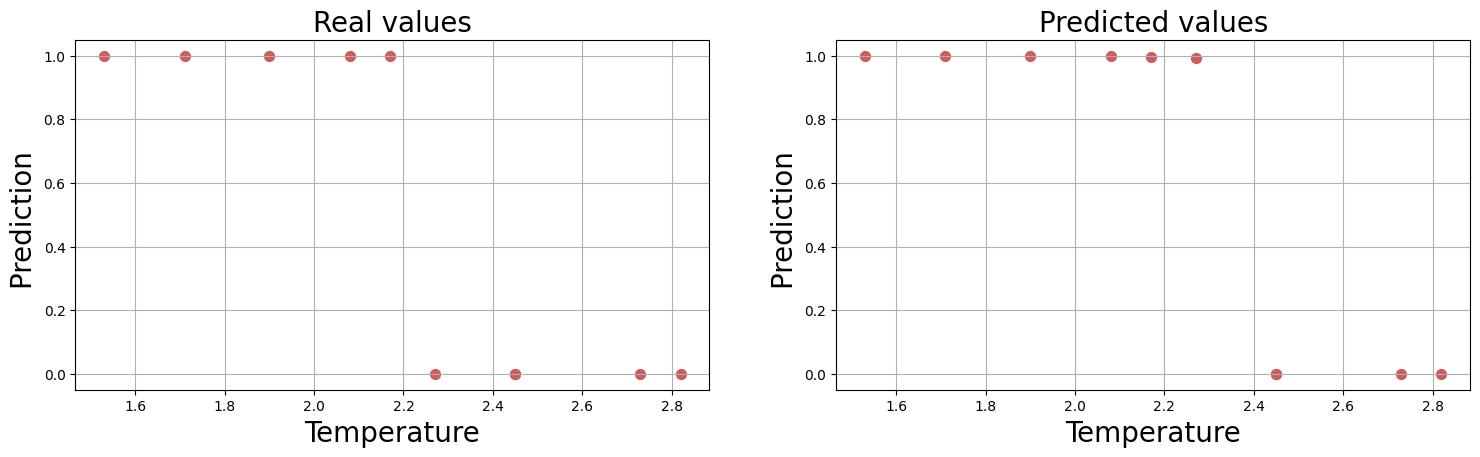

In [43]:
model.train(False)
test_loader = DataLoader(data_test, batch_size=batch,shuffle=False)
test_accuracy = Accuracy(task="binary", num_classes=2)

for x, y, t in test_loader:
    with torch.no_grad():
      #Run inference on test dataset
       #Insert code here
        output = model(x)
        true_values = y
        true_temps = t


# Calculate accuracy
accuracy = test_accuracy(output.flatten(), true_values)
print("Test Accuracy:", accuracy)


#plot Prediction vs tempature for truth and pred
f = plt.figure(figsize=(18, 10));
plt.tight_layout()

sp =  f.add_subplot(2, 2, 1 );
plt.title('Real values', fontsize=20)
plt.grid()
plt.scatter(true_temps, y, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.title('Predicted values', fontsize=20)
plt.grid()
plt.scatter(true_temps, output.flatten(), s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

#Do you get good validation?

The accuracy obtained from testing the neural nework is 0.9.

# Triangle Ising Model

In this case, the interacting neighbors will be 6 for each element of the lattice. Let´s define some functions

In [44]:
"This function creates an array that has the same pattern as shown in the project instructions"

def initialize(N: int):
  iarr = np.zeros((N,N))

  for i in range(N):
    if i%2 == 0:
        cont = 2
    else:
        cont = 0

    for j in range(N):
      if cont == 0:
        iarr[i][j] = -1
        cont += 1
      elif cont == 1:
        iarr[i][j] = 1
        cont += 1
      else:
        iarr[i][j] = 1
        cont = 0

  return iarr

print(initialize(7))

[[ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]]


In [45]:
def hamiltonian(iArr, N: int):
    energy = -1/2 * sum(-iArr[i][j] * ( iArr[i][(j+1) % N] + iArr[i][(j-1) % N]+ iArr[(i+1) % N][j] + iArr[(i-1) % N][j] + iArr[(i-1) % N][(j+1)%N] + iArr[(i+1) % N][(j+1)%N]) for i in range(N) for j in range (N))
    return energy

test = initialize(4)
hamiltonian(test, 4)

-8.0

In [46]:
def flip(i,j,iArr,beta):
    M = len(iArr)
    deltaH = 2*iArr[i][j]*(iArr[i][(j+1) % M] + iArr[i][(j-1) % M]+ iArr[(i+1) % M][j] + iArr[(i-1) % M][j] + iArr[(i-1) % M][(j+1)%M] + iArr[(i+1) % M][(j+1)%M])
    if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*beta)):
      iArr[i][j] *= -1
    return iArr


In [47]:
#Run some checks?
nt = 100
T  = np.round(np.linspace(1.53, 6.86, nt),2);
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
  test = Ising(10,T[temp])
  test.simulate()
  E[temp],M[temp],C[temp],X[temp]=test.lastAvg()


Loading...: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


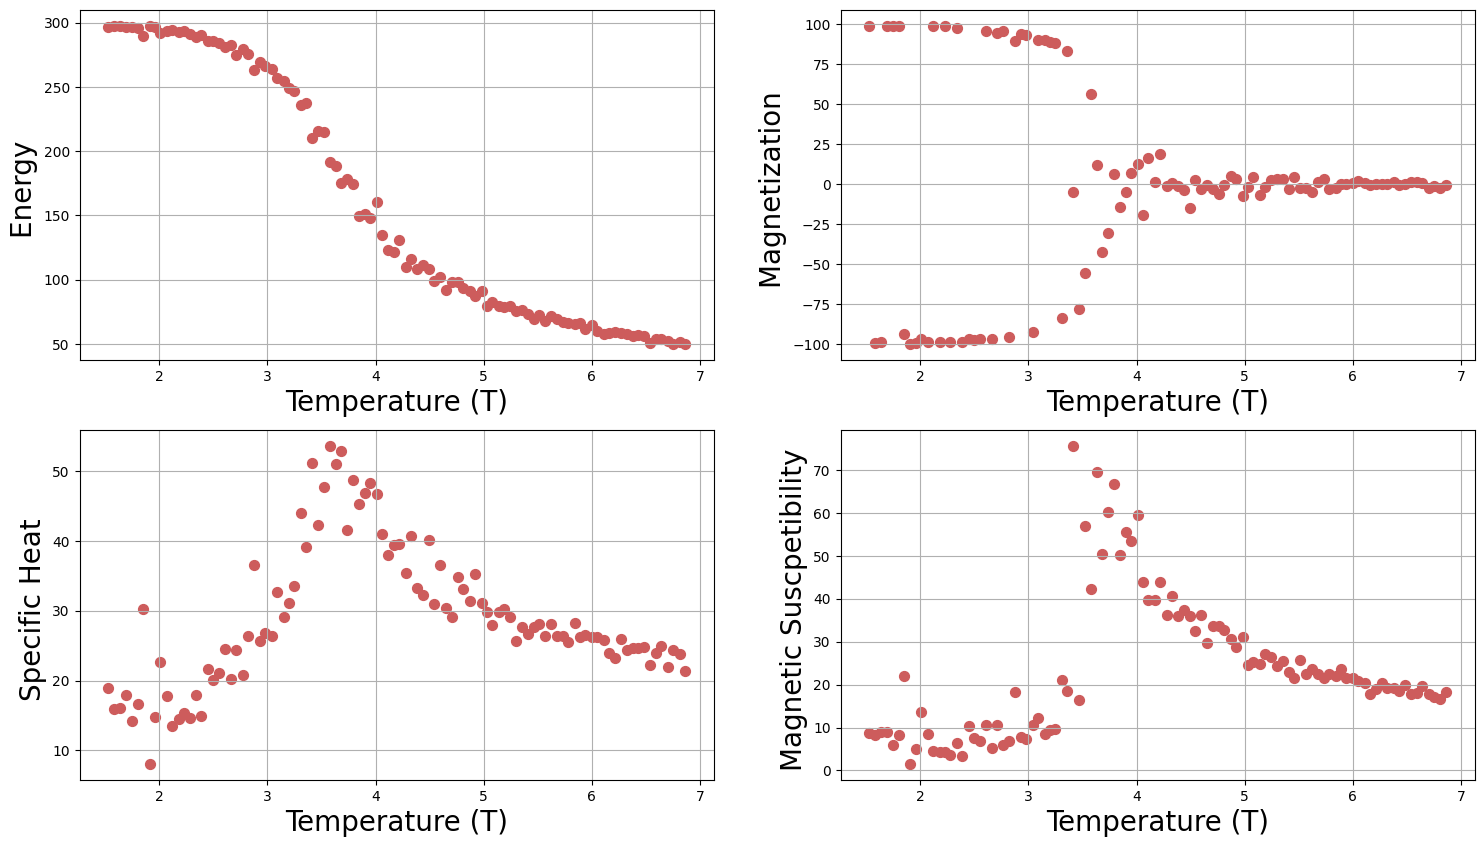

In [48]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid()


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, M, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid()

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid()

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid()

From the results above, we could estimate that the critical temperature for the triangular model is around 3.5 or 4

In [49]:
T_transition = 4/np.log(3)
T_transition

3.6409569065073493

In [50]:
T = np.round(np.linspace(1.53, 6.86, 10),2);
for temp in tqdm (range (10), desc="Loading..."):
    filename='tridata_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(32,T[temp])
    test.nsim=20#500
    test.simulate_save('tri')

Loading...:   0%|          | 0/10 [00:00<?, ?it/s]

sim 0


Loading...:  10%|█         | 1/10 [01:32<13:49, 92.13s/it]

sim 0


Loading...:  20%|██        | 2/10 [03:02<12:06, 90.86s/it]

sim 0


Loading...:  30%|███       | 3/10 [04:32<10:35, 90.79s/it]

sim 0


Loading...:  40%|████      | 4/10 [06:02<09:03, 90.51s/it]

sim 0


Loading...:  50%|█████     | 5/10 [07:30<07:27, 89.56s/it]

sim 0


Loading...:  60%|██████    | 6/10 [08:51<05:46, 86.57s/it]

sim 0


Loading...:  70%|███████   | 7/10 [10:09<04:11, 83.92s/it]

sim 0


Loading...:  80%|████████  | 8/10 [11:29<02:45, 82.58s/it]

sim 0


Loading...:  90%|█████████ | 9/10 [12:47<01:21, 81.12s/it]

sim 0


Loading...: 100%|██████████| 10/10 [14:03<00:00, 84.38s/it]


Loading...: 100%|██████████| 10/10 [00:00<00:00, 704.31it/s]


tensor([3.9000, 3.9000, 6.2700, 2.1200, 5.0800, 4.4900, 2.1200, 5.6800, 3.3100,
        4.4900, 5.6800, 5.6800, 4.4900, 2.7100, 5.6800, 3.3100, 2.7100, 5.0800,
        5.0800, 5.6800, 1.5300, 5.0800, 6.2700, 6.8600, 4.4900, 5.6800, 5.0800,
        5.6800, 1.5300, 2.1200, 5.6800, 1.5300, 1.5300, 3.9000, 1.5300, 3.9000,
        2.7100, 3.9000, 4.4900, 3.9000], dtype=torch.float64)
Test Accuracy: tensor(1.)


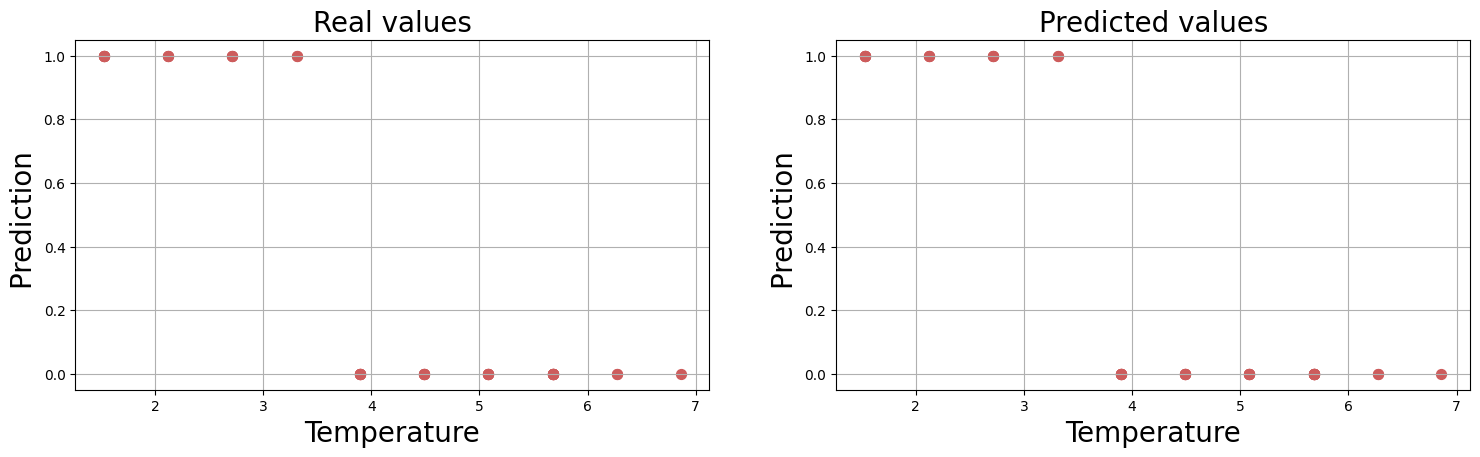

In [51]:
#Now lets test it on something different

"This function returns the testing and training data sets"
def load():
    all_data  = None
    all_temps = None
    for temp in tqdm (range (10), desc="Loading..."):
      f = h5py.File('tridata_'+str(T[temp])+'.h5', 'r')
      if temp == 0:
          all_data  = f['data']
          all_temps = np.ones(all_data.shape[0])*T[temp]
      else:
          all_data  = np.append(all_data, f['data'],axis=0)
          all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*T[temp])

    all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
    all_labels  = np.where(all_temps <= T_transition, 1, 0)
    all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)

    train_size = int(0.8*len(all_dataset))
    data_tri_train, data_tri_test = random_split(all_dataset, [train_size, len(all_dataset) - train_size])

    return data_tri_train, data_tri_test

data_tri_train, data_tri_test = load()
batch=1000
test_tri_loader = DataLoader(data_tri_test, batch_size=batch,shuffle=True)

#again following above, plot the temp applying your prevoiusly trained NN to the triagle boltzman
model.train(False)
model.eval()
for x, y, t in test_tri_loader:
    with torch.no_grad():
      output = model(x)
      true_values = y
      temps = t

print(t)
#What is accuracy?
accuracy = test_accuracy(output.flatten(), true_values)
print("Test Accuracy:", accuracy)

#plot Score vs Temp where is the phase transition, is it consistent with truth see arxiv paper
#plot Prediction vs tempature for truth and pred
f = plt.figure(figsize=(18, 10));
plt.tight_layout()

sp =  f.add_subplot(2, 2, 1 );
plt.title('Real values', fontsize=20)
plt.grid()
plt.scatter(temps, true_values, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.title('Predicted values', fontsize=20)
plt.grid()
plt.scatter(temps, output.flatten(), s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');


# Conclusion

From the above model we were able to detect a Phase transition for both the square and triangle Ising Model. The CNN to classify if a system was below or above the critical temperature was implemented with 0.9 and 1 accuracy.

The values of the critical temperatures obtained agree with the ones in the reference article.